# Import Libraries and Datasets

In [272]:
# EDA - Data Cleaning
import pandas as pd
import numpy as np
import missingno
from collections import Counter
import math

# EDA - Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:.0f}'.format

# Define Functions

In [273]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

In [274]:
excel_file = 'raw/Bank Customer Data 2020 Fall2.xlsx'

df = pd.read_excel(excel_file, sheet_name='Customer', index_col='UNIQUE_KEY')
print(f'Customer dataset shape: {df.shape}')

third = pd.read_excel(excel_file, sheet_name='3rd Party Data', index_col='UNIQUE_KEY')
print(f'Third Party dataset shape: {third.shape}')

dir_mail = pd.read_excel(excel_file, sheet_name='Direct Mail', index_col='UNIQUE_KEY')
print(f'Direct Mail dataset shape: {dir_mail.shape}')

email = pd.read_excel(excel_file, sheet_name='EMail', index_col='UNIQUE_KEY')
print(f'Email dataset shape: {email.shape}')

Customer dataset shape: (5000, 30)
Third Party dataset shape: (5002, 15)
Direct Mail dataset shape: (3476, 3)
Email dataset shape: (18581, 3)


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 763 to 6060102
Data columns (total 30 columns):
annual_revenue           5000 non-null object
Month_on_Book            5000 non-null int64
Checking_avg_Bal         5000 non-null object
Savings_avg_Bal          5000 non-null object
Loans_LOC_avg_Bal        5000 non-null object
CreditCard_avg_Bal       5000 non-null object
CDs_avg_Bal              5000 non-null object
HELoans_HELOC_avg_Bal    5000 non-null object
MMDA_avg_Bal             5000 non-null object
Branch_Visits_3_Mos      5000 non-null object
Branch_Trans_3_Mos       5000 non-null object
ATMVisits_3_Mos          5000 non-null object
ATM_Trans_3_Mos          5000 non-null object
signon_visit_3_Mos       5000 non-null object
signon_trans_3_Mos       5000 non-null object
CC_Visits_3_Mos          5000 non-null object
VRU_visits_3_Mos         5000 non-null object
BP_trans_3_Mos           5000 non-null object
RDC_trans_3_Mos          5000 non-null object
OLB_ENROLLED   

In [276]:
df.columns = df.columns.str.replace(' ','_')
df.head(5)

,annual_revenue,Month_on_Book,Checking_avg_Bal,Savings_avg_Bal,Loans_LOC_avg_Bal,CreditCard_avg_Bal,CDs_avg_Bal,HELoans_HELOC_avg_Bal,MMDA_avg_Bal,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag
UNIQUE_KEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
763,18,366,738,0,0,0,0,0,0,1,1,6,8,15,19,0,0,3,0,1,1,.,1,1,0,0,0,0,0,0
1813,10158,350,23030,0,0,0,445381,0,0,6,6,0,0,0,0,0,1,0,0,1,.,.,0,1,0,0,0,1,0,0
3743,1128,299,7874,32603,0,1146,0,0,0,1,2,8,10,23,28,0,0,0,0,1,1,.,1,1,1,0,1,0,0,0
4180,1247,317,3412,0,0,4751,0,0,0,3,4,23,37,15,20,0,2,0,0,1,1,.,1,1,0,0,1,0,0,0
8222,33,272,1187,0,0,0,0,0,0,0,0,1,2,19,21,0,0,0,0,1,1,1,2,1,0,0,0,0,0,0


In [277]:
df.describe()

,Month_on_Book,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag
count,5000,5000,5000,5000,5000,5000,5000,5000,5000
mean,191,1,1,0,0,0,0,0,0
std,168,1,0,0,0,0,0,0,0
min,1,0,0,0,0,0,0,0,0
25%,52,0,1,0,0,0,0,0,0
50%,154,1,1,0,0,0,0,0,0
75%,297,2,1,0,0,1,0,0,0
max,1418,2,1,1,1,1,1,1,1


# Data Due Diligence

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 763 to 6060102
Data columns (total 30 columns):
annual_revenue           5000 non-null object
Month_on_Book            5000 non-null int64
Checking_avg_Bal         5000 non-null object
Savings_avg_Bal          5000 non-null object
Loans_LOC_avg_Bal        5000 non-null object
CreditCard_avg_Bal       5000 non-null object
CDs_avg_Bal              5000 non-null object
HELoans_HELOC_avg_Bal    5000 non-null object
MMDA_avg_Bal             5000 non-null object
Branch_Visits_3_Mos      5000 non-null object
Branch_Trans_3_Mos       5000 non-null object
ATMVisits_3_Mos          5000 non-null object
ATM_Trans_3_Mos          5000 non-null object
signon_visit_3_Mos       5000 non-null object
signon_trans_3_Mos       5000 non-null object
CC_Visits_3_Mos          5000 non-null object
VRU_visits_3_Mos         5000 non-null object
BP_trans_3_Mos           5000 non-null object
RDC_trans_3_Mos          5000 non-null object
OLB_ENROLLED   

## Customer Dataset

<b> Note: </b> After reviewing the dataset initially, I found '.' characters scattered throughout many of the numeric columns, so I am going to replace these values with null values and review as if they are missing.

In [279]:
df = df.replace('.', np.nan)
df

,annual_revenue,Month_on_Book,Checking_avg_Bal,Savings_avg_Bal,Loans_LOC_avg_Bal,CreditCard_avg_Bal,CDs_avg_Bal,HELoans_HELOC_avg_Bal,MMDA_avg_Bal,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag
UNIQUE_KEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
763,18,366,738,0,0,0,0,0,0,1,1,6,8,15,19,0,0,3,0,1,1,nan,1,1,0,0,0,0,0,0
1813,10158,350,23030,0,0,0,445381,0,0,6,6,0,0,0,0,0,1,0,0,1,nan,nan,0,1,0,0,0,1,0,0
3743,1128,299,7874,32603,0,1146,0,0,0,1,2,8,10,23,28,0,0,0,0,1,1,nan,1,1,1,0,1,0,0,0
4180,1247,317,3412,0,0,4751,0,0,0,3,4,23,37,15,20,0,2,0,0,1,1,nan,1,1,0,0,1,0,0,0
8222,33,272,1187,0,0,0,0,0,0,0,0,1,2,19,21,0,0,0,0,1,1,1,2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6050258,10,29,526,0,0,0,0,0,0,3,5,5,9,90,141,1,1,0,0,1,1,1,2,1,0,0,0,0,0,0
6051481,309,29,0,0,10866,0,0,0,0,0,0,0,0,5,6,0,0,0,0,1,1,nan,1,0,0,1,0,0,0,0
6052608,-189,29,0,0,0,0,0,4143,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,0,0,0,0,0,0,1,0


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 763 to 6060102
Data columns (total 30 columns):
annual_revenue           4992 non-null float64
Month_on_Book            5000 non-null int64
Checking_avg_Bal         4979 non-null float64
Savings_avg_Bal          4979 non-null float64
Loans_LOC_avg_Bal        4979 non-null float64
CreditCard_avg_Bal       4979 non-null float64
CDs_avg_Bal              4979 non-null float64
HELoans_HELOC_avg_Bal    4979 non-null float64
MMDA_avg_Bal             4979 non-null float64
Branch_Visits_3_Mos      4992 non-null float64
Branch_Trans_3_Mos       4992 non-null float64
ATMVisits_3_Mos          4992 non-null float64
ATM_Trans_3_Mos          4992 non-null float64
signon_visit_3_Mos       4992 non-null float64
signon_trans_3_Mos       4992 non-null float64
CC_Visits_3_Mos          4992 non-null float64
VRU_visits_3_Mos         4992 non-null float64
BP_trans_3_Mos           4992 non-null float64
RDC_trans_3_Mos          4992 non-null float

As you can see from the output above, replacing the .'s worked. All values are now numeric so the next step is to begin reviewing columns with null values.

In [281]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
MOBILE_ACTIVE,2997
OLB_ACTIVE,1311
OLB_ENROLLED,640
Checking_avg_Bal,21
Savings_avg_Bal,21
Loans_LOC_avg_Bal,21
CreditCard_avg_Bal,21
CDs_avg_Bal,21
HELoans_HELOC_avg_Bal,21


<b> Note: </b>The MOBILE_ACTIVE, OLB_ACTIVE, AND OLB_ENROLLED columns have many nulls but look to be binary in nature. 

<b> Action: </b>Below review the value counts for each before I can make any assumptions.

In [282]:
print(pd.value_counts(df['MOBILE_ACTIVE'], dropna=False), '\n')
print(pd.value_counts(df['OLB_ACTIVE'], dropna=False), '\n')
print(pd.value_counts(df['OLB_ENROLLED'], dropna=False))

nan    2997
1      2003
Name: MOBILE_ACTIVE, dtype: int64 

1      3689
nan    1311
Name: OLB_ACTIVE, dtype: int64 

1      4360
nan     640
Name: OLB_ENROLLED, dtype: int64


<b> Note: </b>It is confirmed. Each column is missing its 0 binary value.

<b> Action: </b>I will replace the nulls with 0 and rerun the code to assess the remaining null values.

In [283]:
df.MOBILE_ACTIVE.replace(np.NaN, 0, inplace=True)
df.OLB_ACTIVE.replace(np.NaN, 0, inplace=True)
df.OLB_ENROLLED.replace(np.NaN, 0, inplace=True)

In [284]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
Checking_avg_Bal,21
Savings_avg_Bal,21
Loans_LOC_avg_Bal,21
CreditCard_avg_Bal,21
CDs_avg_Bal,21
HELoans_HELOC_avg_Bal,21
MMDA_avg_Bal,21
signon_trans_3_Mos,8
CC_Visits_3_Mos,8


<b> Note: </b>Many of the missing values look to be related to the same customers. 

<b> Action: </b>Since there are only 21 (out of 5,000 records), it makes sense to filter them from the dataset.

In [285]:
df.loc[df['Checking_avg_Bal'].isnull()].describe()

,annual_revenue,Month_on_Book,Checking_avg_Bal,Savings_avg_Bal,Loans_LOC_avg_Bal,CreditCard_avg_Bal,CDs_avg_Bal,HELoans_HELOC_avg_Bal,MMDA_avg_Bal,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag
count,21,21,0,0,0,0,0,0,0,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
mean,128,20,nan,nan,nan,nan,nan,nan,nan,2,2,1,2,7,11,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0
std,198,41,nan,nan,nan,nan,nan,nan,nan,1,2,5,6,13,20,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
min,0,1,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,8,1,nan,nan,nan,nan,nan,nan,nan,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
50%,19,1,nan,nan,nan,nan,nan,nan,nan,1,1,0,0,2,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
75%,113,17,nan,nan,nan,nan,nan,nan,nan,2,3,0,0,5,11,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0
max,596,166,nan,nan,nan,nan,nan,nan,nan,6,7,22,29,41,64,1,4,0,1,1,1,1,2,1,1,1,1,0,0,1


In [286]:
df = df.loc[df['Checking_avg_Bal'].notnull()]

In [287]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
signon_trans_3_Mos,8
RDC_trans_3_Mos,8
Branch_Visits_3_Mos,8
Branch_Trans_3_Mos,8
ATMVisits_3_Mos,8
ATM_Trans_3_Mos,8
signon_visit_3_Mos,8
CC_Visits_3_Mos,8
VRU_visits_3_Mos,8


In [288]:
df.loc[df['signon_trans_3_Mos'].isnull()].describe()

,annual_revenue,Month_on_Book,Checking_avg_Bal,Savings_avg_Bal,Loans_LOC_avg_Bal,CreditCard_avg_Bal,CDs_avg_Bal,HELoans_HELOC_avg_Bal,MMDA_avg_Bal,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag
count,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,8,8,8,8,8,8,8,8,8,8,8
mean,449,105,8622,0,554,103,1259,5846,4753,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1,1,1,1,0,0,0,0,0,0
std,604,66,8729,0,1566,290,3560,16536,13078,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,1,1,0,0,0,0,0,0,0
min,81,37,1905,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,1,0,0,0,0,0,0
25%,109,42,2410,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1,0,1,1,0,0,0,0,0,0
50%,271,104,4548,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1,1,2,1,0,0,0,0,0,0
75%,389,141,12094,0,0,0,0,0,229,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1,1,2,1,0,0,0,0,0,0
max,1892,215,24824,0,4429,821,10069,46770,37110,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1,1,2,1,0,1,1,1,1,1


Similar to the previous step, the 8 customers seem to all be missing values, so I will filter them out as well.

In [289]:
df = df.loc[df['Branch_Visits_3_Mos'].notnull()]

In [290]:
df.describe()

,annual_revenue,Month_on_Book,Checking_avg_Bal,Savings_avg_Bal,Loans_LOC_avg_Bal,CreditCard_avg_Bal,CDs_avg_Bal,HELoans_HELOC_avg_Bal,MMDA_avg_Bal,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag
count,4963,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971,4971
mean,750,192,7302,1883,874,594,3014,5718,7063,2,3,7,11,35,65,0,1,3,0,1,1,0,1,1,0,0,0,0,0,0
std,1410,168,25022,8623,5684,2248,26703,28452,38333,3,5,12,21,43,113,1,4,9,2,0,0,0,1,0,0,0,0,0,0,0
min,-15248,2,-778,-50,-17,-4856,0,-333,-84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,73,53,370,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
50%,292,155,1497,0,0,0,0,0,0,1,1,2,2,17,21,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0
75%,863,298,5290,0,0,0,0,0,0,3,4,10,14,56,81,0,1,0,0,1,1,1,2,1,0,0,1,0,0,0
max,36300,1418,722269,147008,274435,31903,708128,787601,1542752,37,76,161,290,250,1435,46,65,108,86,1,1,1,2,1,1,1,1,1,1,1


In [291]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
annual_revenue,8


Finally, there are 8 missing annual review values. I will replace these values with the median value.

In [292]:
df.annual_revenue.fillna(df.annual_revenue.median(), inplace=True)

In [293]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,


## What variable defines business value? - Customer Value

<b> Note: </b>Customer value is defined as the dependent variable of the linear regression model you’ll build
+ DV = Sum of balance across all accounts (total account balance)

Additionally, since the DV is the sum of all balances, I am going to remove the avg balances from the dataset as part of this analysis.

In [294]:
value_columns = ['Checking_avg_Bal', 
                  'Savings_avg_Bal', 
                  'Loans_LOC_avg_Bal', 
                  'CreditCard_avg_Bal', 
                  'CDs_avg_Bal',
                  'HELoans_HELOC_avg_Bal', 
                  'MMDA_avg_Bal']

df['Customer Value'] = df['Checking_avg_Bal']+df['Savings_avg_Bal']+df['Loans_LOC_avg_Bal']+df['CreditCard_avg_Bal']+df['CDs_avg_Bal']+df['HELoans_HELOC_avg_Bal']+df['MMDA_avg_Bal']

df.drop(columns=value_columns, inplace=True)

<b> Note: </b>This concludes the missing values & business value variable review. Up next, I will review the additional datasets to leverage the following sources:
+ 3rd Party Data
+ Direct Mail
+ Emails

## 3rd Party Dataset

In [295]:
third.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5002 entries, 763.0 to nan
Data columns (total 15 columns):
Customer Value          5000 non-null float64
Number_of_Children      5000 non-null object
Family_composition      5000 non-null object
Gender_P1               5000 non-null object
marital_status_P1       5000 non-null object
Dwelling_Type           5000 non-null object
Number_of_Adults        5002 non-null object
Length_of_Residence     5000 non-null object
Household_Age           5000 non-null object
Household_Size          5000 non-null object
HH_EDUCATION_VALUE      5000 non-null object
HH_INCOME2              5000 non-null object
Occupation              5000 non-null object
Liquid_Resources        5000 non-null object
Investment_Resources    5000 non-null object
dtypes: float64(1), object(14)
memory usage: 625.2+ KB


<b> Note: </b>To be consistent, I am going to add an underscore to repalce a space in the column names.

In [296]:
third.columns = third.columns.str.replace(' ','_')

In [297]:
third.head(5)

,Customer_Value,Number_of_Children,Family_composition,Gender_P1,marital_status_P1,Dwelling_Type,Number_of_Adults,Length_of_Residence,Household_Age,Household_Size,HH_EDUCATION_VALUE,HH_INCOME2,Occupation,Liquid_Resources,Investment_Resources
UNIQUE_KEY,,,,,,,,,,,,,,,
763,738,.,8,2,1,1,2,7,7,2,4,6,14,8,5
1813,468411,.,8,2,1,1,2,8,6,2,2,3,13,3,3
3743,41623,.,14,2,2,1,2,8,5,2,2,6,14,5,8
4180,8164,.,6,1,2,1,2,8,4,2,3,2,0,1,2
8222,1187,.,14,2,2,5,1,4,2,1,4,4,0,7,4


In [298]:
third.describe()

,Customer_Value
count,5000
mean,26330
std,63029
min,-778
25%,939
50%,5196
75%,22963
max,1549653


<b>Note: </b>Again, there looks to be many .'s where missing values should be.

In [299]:
third = third.replace('.', np.nan)

In [300]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(third.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
Number_of_Children,3933
Family_composition,220
Investment_Resources,187
Liquid_Resources,187
Occupation,98
Dwelling_Type,93
HH_EDUCATION_VALUE,36
Household_Size,36
Household_Age,36


<b>Action: </b>After reviewing the missing values, I am going to take the following steps:
+ Number_of_Children - replace missing values with 0 (according to the data dictionary, missing = 0
+ Occupation - NaN is replace with '00', as this is classified as Unknown
+ Dwelling_Type - NaN is replaed with 0, as this is classified as Unkown
+ Family_composition - filter out any nulls, as this may throw off many other variables associated

<b>Note: </b>Removing the 220 null values in Family_composition removed all other nulls for remaining columns. No nulls exist at this point in time.

In [301]:
third['Number_of_Children'].fillna(0, inplace=True)

In [302]:
third['Occupation'].fillna('00', inplace=True)
third['Dwelling_Type'].fillna(0, inplace=True)

third = third.loc[third['Family_composition'].notnull()]

## Direct Mail Dataset

The dataset provides each mailing to each customer and for what reason. After my initial assessment I am going to transform the data by doing the following:

+ Removing the Send_DATE column since I care about the number of mailings more so than when they were sent
+ Grouping the data by the type of mailings completed for each customer

The outcome will create an individual row for each customer outlining the necessary fields for my analysis. 

Then the dataset will be joined to the original customer dataset flagging the type of direct mail contact that was made to a customer (1 = yes, 0 = no).

In [303]:
dir_mail

,Campaign_Name,Send_DATE,Product_category
UNIQUE_KEY,,,
8222,RTXCBK0719,2019-07-09,Creidt Card
8222,RTXLAT0519,2019-06-04,Credit Card
8222,RTXUPL0919,2019-09-03,Credit
9362,RTXUPL0719,2019-07-09,Credit
9362,RTXUPL0919,2019-09-03,Credit
...,...,...,...
6052608,RTXCBK0919,2019-09-03,Creidt Card
6053715,RTXCBK0719,2019-07-09,Creidt Card
6053715,RTXCBK0919,2019-09-03,Creidt Card


In [304]:
pd.value_counts(dir_mail['Product_category'])

Creidt Card          1529
Credit               1140
Credit Card           773
Auto-Refinance         21
Home Equity (ITA)      13
Name: Product_category, dtype: int64

In [305]:
dir_mail['Product_category'].replace(to_replace={'Creidt Card':'Credit Card', 'Credit':'Credit Card'}, inplace=True)

In [306]:
dir_mail = dir_mail.groupby(by=['UNIQUE_KEY', 'Product_category']).agg('count').reset_index()
dir_mail.drop(columns=['Send_DATE'], inplace=True)
dir_mail.set_index('UNIQUE_KEY', inplace=True)
dir_mail

,Product_category,Campaign_Name
UNIQUE_KEY,,
8222,Credit Card,3
9362,Credit Card,2
15870,Credit Card,1
18084,Credit Card,1
21086,Credit Card,1
...,...,...
5934059,Home Equity (ITA),1
5947040,Credit Card,3
6052608,Credit Card,2


In [307]:
dir_mail = dir_mail.pivot_table(values='Campaign_Name', 
                                index=dir_mail.index, 
                                columns='Product_category', 
                                aggfunc='count').fillna(0).astype(int)

dir_mail['DirectMail_SENT'] = 1

In [308]:
dir_mail.columns = dir_mail.columns.str.replace(' ','_')
dir_mail.columns = dir_mail.columns.str.replace('-','_')
dir_mail.columns = dir_mail.columns.str.replace('(','')
dir_mail.columns = dir_mail.columns.str.replace(')','')
dir_mail

Product_category,Auto_Refinance,Credit_Card,Home_Equity_ITA,DirectMail_SENT
UNIQUE_KEY,,,,
8222,0,1,0,1
9362,0,1,0,1
15870,0,1,0,1
18084,0,1,0,1
21086,0,1,0,1
...,...,...,...,...
5934059,0,0,1,1
5947040,0,1,0,1
6052608,0,1,0,1


## Email Dataset

In [309]:
email

,Campaign_Code,ACTION_DATE,ACTION_CODE
UNIQUE_KEY,,,
763,CCDCPS2019,2019-06-14,Send
763,RTXKAS0519,2019-06-03,Send
763,RTXOEM0719,2019-07-17,Send
763,CCDCPS2019,2019-06-19,Open
763,CCDCPS2019,2019-06-19,Click
...,...,...,...
6052608,RTXCBK0719,2019-07-23,Send
6052608,RTXOEM0719,2019-07-17,Send
6053715,RTXCBK0719,2019-07-23,Send


In [310]:
email = email.groupby(by=['UNIQUE_KEY', 'ACTION_CODE']).agg('count').reset_index()
email.drop(columns=['ACTION_DATE'], inplace=True)
email.set_index('UNIQUE_KEY', inplace=True)
email

,ACTION_CODE,Campaign_Code
UNIQUE_KEY,,
763,Click,1
763,Open,1
763,Send,3
1813,Send,2
3743,Send,3
...,...,...
6050258,Send,4
6051481,Send,1
6052608,Send,2


In [311]:
email = email.pivot_table(values='Campaign_Code', 
                                index=email.index, 
                                columns='ACTION_CODE', 
                                aggfunc='count').fillna(0).astype(int)

email['Email_SENT'] = 1

In [312]:
email

ACTION_CODE,Click,Open,Send,Email_SENT
UNIQUE_KEY,,,,
763,1,1,1,1
1813,0,0,1,1
3743,0,0,1,1
4180,0,0,1,1
8222,0,1,1,1
...,...,...,...,...
6050258,0,0,1,1
6051481,0,0,1,1
6052608,0,0,1,1


# Join Datasets

## 3rd Party Dataset

In [313]:
print('Shape - Before: ', df.shape)
df1 = df.join(third)
print('Shape - After: ', df1.shape)

Shape - Before:  (4971, 24)
Shape - After:  (4971, 39)


After joining the 3rd party dataset, I need to be aware that I will not be missing values for a number of columns that I removed from the third part data set (218 customers impacted).

<b> Action: </b> I will be removing these 218 customers from the analysis to utilzie the 3rd part data for the entire set of customers.

In [314]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df1.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
Investment_Resources,218
Number_of_Adults,218
Liquid_Resources,218
Customer_Value,218
Family_composition,218
Gender_P1,218
marital_status_P1,218
Dwelling_Type,218
Number_of_Children,218


In [315]:
df1 = df1.loc[df1['Investment_Resources'].notnull()]
print('New Shape of df1 after taking action:', df1.shape)

New Shape of df1 after taking action: (4753, 39)


<b>Note: </b>We now have 4,735 customers to use for the remainder of this analysis. I do not believe we wiped out a significant enough portion of the sample to prevent moving forward.

<b>Action: </b>As a control check, I am now going to compare the 'Customer Value' column created in the 1st party dataset to there 'Customer_Value column provided in the 3rd party dataset.

In [316]:
col_num = len(df1.loc[df1['Customer Value'] == df1['Customer_Value']])
print(f'The number of columns where the Customer Value and Customer_Value columns equal are: {col_num}')

The number of columns where the Customer Value and Customer_Value columns equal are: 4753


<b>Note: </b>The above columns match the entire data set. This control is met, so I can drop one and move forward.

In [317]:
df1.drop(columns='Customer Value', inplace=True)

## Direct Mail Dataset

In [318]:
print('Shape - Before: ', df1.shape)
df2 = df1.join(dir_mail).fillna(0)
print('Shape - After: ', df2.shape)
df2

Shape - Before:  (4753, 38)
Shape - After:  (4753, 42)


,annual_revenue,Month_on_Book,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag,Customer_Value,Number_of_Children,Family_composition,Gender_P1,marital_status_P1,Dwelling_Type,Number_of_Adults,Length_of_Residence,Household_Age,Household_Size,HH_EDUCATION_VALUE,HH_INCOME2,Occupation,Liquid_Resources,Investment_Resources,Auto_Refinance,Credit_Card,Home_Equity_ITA,DirectMail_SENT
UNIQUE_KEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
763,18,366,1,1,6,8,15,19,0,0,3,0,1,1,0,1,1,0,0,0,0,0,0,738,0,8,2,1,1,2,7,7,2,4,6,14,8,5,0,0,0,0
1813,10158,350,6,6,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,468411,0,8,2,1,1,2,8,6,2,2,3,13,3,3,0,0,0,0
3743,1128,299,1,2,8,10,23,28,0,0,0,0,1,1,0,1,1,1,0,1,0,0,0,41623,0,14,2,2,1,2,8,5,2,2,6,14,5,8,0,0,0,0
4180,1247,317,3,4,23,37,15,20,0,2,0,0,1,1,0,1,1,0,0,1,0,0,0,8164,0,6,1,2,1,2,8,4,2,3,2,0,1,2,0,0,0,0
8222,33,272,0,0,1,2,19,21,0,0,0,0,1,1,1,2,1,0,0,0,0,0,0,1187,0,14,2,2,5,1,4,2,1,4,4,0,7,4,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6050258,10,29,3,5,5,9,90,141,1,1,0,0,1,1,1,2,1,0,0,0,0,0,0,526,0,2,1,1,1,2,1,3,3,3,7,0,3,8,0,0,0,0
6051481,309,29,0,0,0,0,5,6,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,10866,0,2,2,1,1,2,4,3,3,3,6,0,1,5,0,0,0,0
6052608,-189,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4143,1,11,1,2,1,1,5,3,2,2,5,0,2,5,0,1,0,1


In [319]:
pd.value_counts(df2['DirectMail_SENT'], dropna=False)

0    2966
1    1787
Name: DirectMail_SENT, dtype: int64

## Email Dataset

In [320]:
print('Shape - Before: ', df2.shape)
df3 = df2.join(email).fillna(0)
print('Shape - After: ', df3.shape)
df3

Shape - Before:  (4753, 42)
Shape - After:  (4753, 46)


,annual_revenue,Month_on_Book,Branch_Visits_3_Mos,Branch_Trans_3_Mos,ATMVisits_3_Mos,ATM_Trans_3_Mos,signon_visit_3_Mos,signon_trans_3_Mos,CC_Visits_3_Mos,VRU_visits_3_Mos,BP_trans_3_Mos,RDC_trans_3_Mos,OLB_ENROLLED,OLB_ACTIVE,MOBILE_ACTIVE,Active_user,Checking_flag,Savings_flag,Loans_LOC_flag,CreditCard_flag,CDs_flag,HELoans_HELOC_flag,MMDA_flag,Customer_Value,Number_of_Children,Family_composition,Gender_P1,marital_status_P1,Dwelling_Type,Number_of_Adults,Length_of_Residence,Household_Age,Household_Size,HH_EDUCATION_VALUE,HH_INCOME2,Occupation,Liquid_Resources,Investment_Resources,Auto_Refinance,Credit_Card,Home_Equity_ITA,DirectMail_SENT,Click,Open,Send,Email_SENT
UNIQUE_KEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
763,18,366,1,1,6,8,15,19,0,0,3,0,1,1,0,1,1,0,0,0,0,0,0,738,0,8,2,1,1,2,7,7,2,4,6,14,8,5,0,0,0,0,1,1,1,1
1813,10158,350,6,6,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,468411,0,8,2,1,1,2,8,6,2,2,3,13,3,3,0,0,0,0,0,0,1,1
3743,1128,299,1,2,8,10,23,28,0,0,0,0,1,1,0,1,1,1,0,1,0,0,0,41623,0,14,2,2,1,2,8,5,2,2,6,14,5,8,0,0,0,0,0,0,1,1
4180,1247,317,3,4,23,37,15,20,0,2,0,0,1,1,0,1,1,0,0,1,0,0,0,8164,0,6,1,2,1,2,8,4,2,3,2,0,1,2,0,0,0,0,0,0,1,1
8222,33,272,0,0,1,2,19,21,0,0,0,0,1,1,1,2,1,0,0,0,0,0,0,1187,0,14,2,2,5,1,4,2,1,4,4,0,7,4,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6050258,10,29,3,5,5,9,90,141,1,1,0,0,1,1,1,2,1,0,0,0,0,0,0,526,0,2,1,1,1,2,1,3,3,3,7,0,3,8,0,0,0,0,0,0,1,1
6051481,309,29,0,0,0,0,5,6,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,10866,0,2,2,1,1,2,4,3,3,3,6,0,1,5,0,0,0,0,0,0,1,1
6052608,-189,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4143,1,11,1,2,1,1,5,3,2,2,5,0,2,5,0,1,0,1,0,0,1,1


In [321]:
pd.value_counts(df3['Email_SENT'], dropna=False)

1    4753
Name: Email_SENT, dtype: int64

After reviewing, we send an email to all customers, so the column Email_SENT & Send can be dropped.

In [322]:
df3.drop(columns=['Email_SENT', 'Send'], inplace=True)

## Final Data Due Diligence Steps

## Final review of null values

In [323]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df3.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,


## Final Review of Non-numeric columns

In [324]:
print('The below displays columns that are non-numeric data types: \n')
df3.select_dtypes(exclude='number').info()

The below displays columns that are non-numeric data types: 

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 3 columns):
Gender_P1            4753 non-null object
marital_status_P1    4753 non-null object
HH_INCOME2           4753 non-null object
dtypes: object(3)
memory usage: 308.5+ KB


<b>Action: </b>Review the three following columns that are non-numeric:
+ Gender_P1
+ marital_status_P1
+ HH_INCOME2

In [325]:
pd.value_counts(df3['Gender_P1'], dropna=False)

1    2385
2    2289
       65
3      14
Name: Gender_P1, dtype: int64

In [326]:
df3.loc[df3['Gender_P1']==' '].Family_composition.value_counts()

12    20
14    18
2     12
1      4
6      3
5      2
4      2
8      2
16     1
11     1
Name: Family_composition, dtype: int64

<b>Note: </b>Based on the above, my primary guestimate of missing values is to input 1 (male) in to the field. However, using the 'Family_composition' column values, I can better estimate the Gender_P1. 

<b>Note: </b>Additionally, after reviewing the Gender_P1 column and seeing such a low number under the Neutral field, 

<b>Action: </b>I have decided to simply replace 3 (neutral) with a 1 (male). This impact 15 of 50 customers and ensures the Gender_P1 column values are now binary in nature.

In [327]:
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==1), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==2), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==4), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==5), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==6), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==8), 'Gender_P1'] = 2
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==11), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==12), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==14), 'Gender_P1'] = 2
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==16), 'Gender_P1'] = 3


df3['Gender_P1'] = df3['Gender_P1'].astype(int)
df3['Gender_P1'].replace(3, 1, inplace=True)

<b>Note: </b>Marital Status: I am going to use the Family composition column to help use logic and determine what the marital status of the customer is.

In [328]:
pd.value_counts(df3['marital_status_P1'], dropna=False)

1    2549
2    1368
      836
Name: marital_status_P1, dtype: int64

In [329]:
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==1), 'marital_status_P1'] = 1
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==2), 'marital_status_P1'] = 1
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==3), 'marital_status_P1'] = 3
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==4), 'marital_status_P1'] = 3
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==5), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==6), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==7), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==8), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==11), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==12), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==13), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==14), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==16), 'marital_status_P1'] = 2

df3['marital_status_P1'] = df3['marital_status_P1'].astype(int)

<b>Action: </b> Reviewing the 'HH_INCOME2' column values.

In [330]:
pd.value_counts(df3['HH_INCOME2'], dropna=False)

6    957
7    714
5    520
8    418
4    414
3    413
9    365
1    220
A    218
B    157
2    157
C    146
D     54
Name: HH_INCOME2, dtype: int64

<b>Note: </b>No action taken after reviewing the data dictionary. This variable should be an object.

In [331]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 44 columns):
annual_revenue          4753 non-null float64
Month_on_Book           4753 non-null int64
Branch_Visits_3_Mos     4753 non-null float64
Branch_Trans_3_Mos      4753 non-null float64
ATMVisits_3_Mos         4753 non-null float64
ATM_Trans_3_Mos         4753 non-null float64
signon_visit_3_Mos      4753 non-null float64
signon_trans_3_Mos      4753 non-null float64
CC_Visits_3_Mos         4753 non-null float64
VRU_visits_3_Mos        4753 non-null float64
BP_trans_3_Mos          4753 non-null float64
RDC_trans_3_Mos         4753 non-null float64
OLB_ENROLLED            4753 non-null float64
OLB_ACTIVE              4753 non-null float64
MOBILE_ACTIVE           4753 non-null float64
Active_user             4753 non-null int64
Checking_flag           4753 non-null int64
Savings_flag            4753 non-null int64
Loans_LOC_flag          4753 non-null int64
CreditCard_flag         4753 

# Exploratory Data Analysis

## Assess and Remove Outliers

### Remove Outliers from annual_revenue and Customer_Value

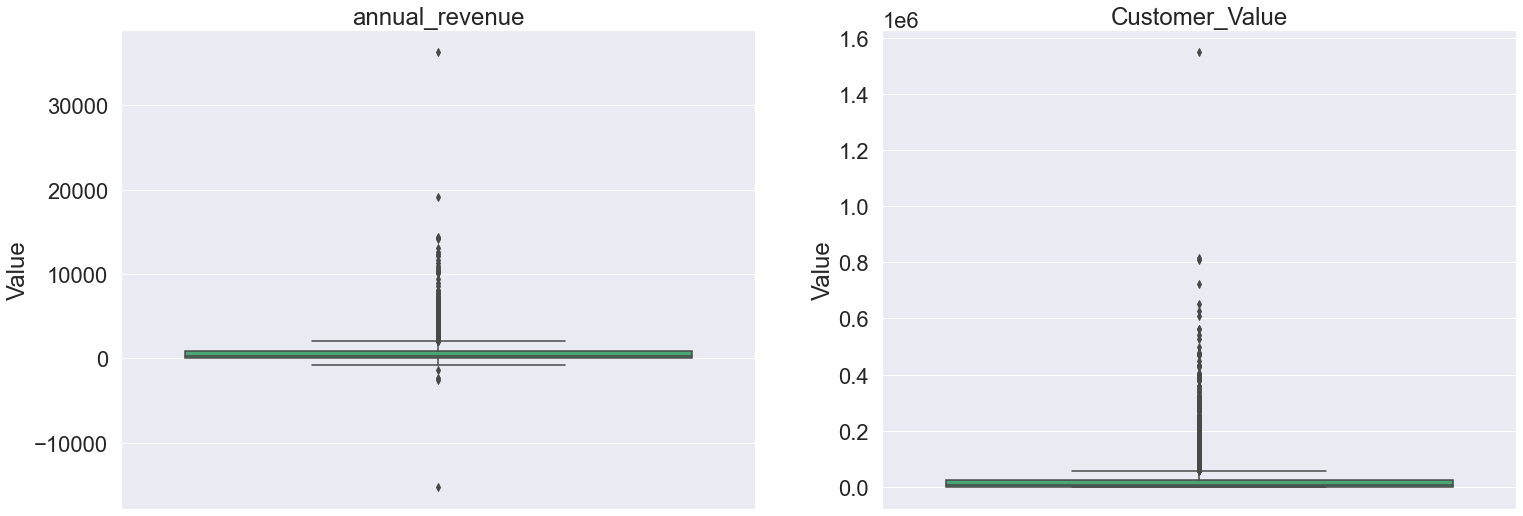

In [332]:
feature_num = list(enumerate(df3[['annual_revenue', 'Customer_Value']].columns))
feature_num
plt.figure(figsize = (25,125))
sns.set(font_scale = 2)

for i in feature_num:
    plt.subplot(12,2,i[0]+1)
    sns.boxplot(y = i[1],
                   data = df3,
                   color='mediumseagreen')

    plt.title(str(i[1]))
    plt.ylabel('Value')
    plt.xticks(rotation = 45)

In [333]:
df3[['annual_revenue', 'Customer_Value']].describe()

,annual_revenue,Customer_Value
count,4753,4753
mean,763,26962
std,1427,63878
min,-15248,-778
25%,76,1026
50%,300,5523
75%,884,23773
max,36300,1549653


<b>Action: </b> Review the 99th and 1st percentiles to determine how I would like to proceed with outliers.

In [334]:
ann_rev_Q99 = np.percentile(df3['annual_revenue'], 99)
print(f'The 99th percentile in annual_revenue is:{ann_rev_Q99}')
ann_rev_Q1 = np.percentile(df3['annual_revenue'], 1)
print(f'The 1st percentile in annual_revenue is:{ann_rev_Q1}\n')

cus_val_Q99 = np.percentile(df3['Customer_Value'], 99)
print(f'The 99th percentile in Customer_Value is:{cus_val_Q99}')
cus_val_Q99 = np.percentile(df3['Customer_Value'], 1)
print(f'The 1st percentile in Customer_Value is:{cus_val_Q99}')

The 99th percentile in annual_revenue is:6374.407599999987
The 1st percentile in annual_revenue is:-40.2052

The 99th percentile in Customer_Value is:296261.62613333133
The 1st percentile in Customer_Value is:0.0


<b>Action: </b> Below is a summary of the action to take for each columns:

annual_revenue column:
+ Ceiling: Use 99th percentile at 6400
+ Floor: Use 0 as the lowest allowable value

Customer_Value columns:
+ Ceiling: Use a number approximating the 99th percentile ($300,00)
+ Floor: Use 0 as the lowest allowable value

In [335]:
df3.loc[df3['annual_revenue']>6374.4, 'annual_revenue'] = 6400
df3.loc[df3['annual_revenue']<0, 'annual_revenue'] = 0

df3.loc[df3['Customer_Value']>296261.62, 'Customer_Value'] = 300000
df3.loc[df3['Customer_Value']<0, 'Customer_Value'] = 0

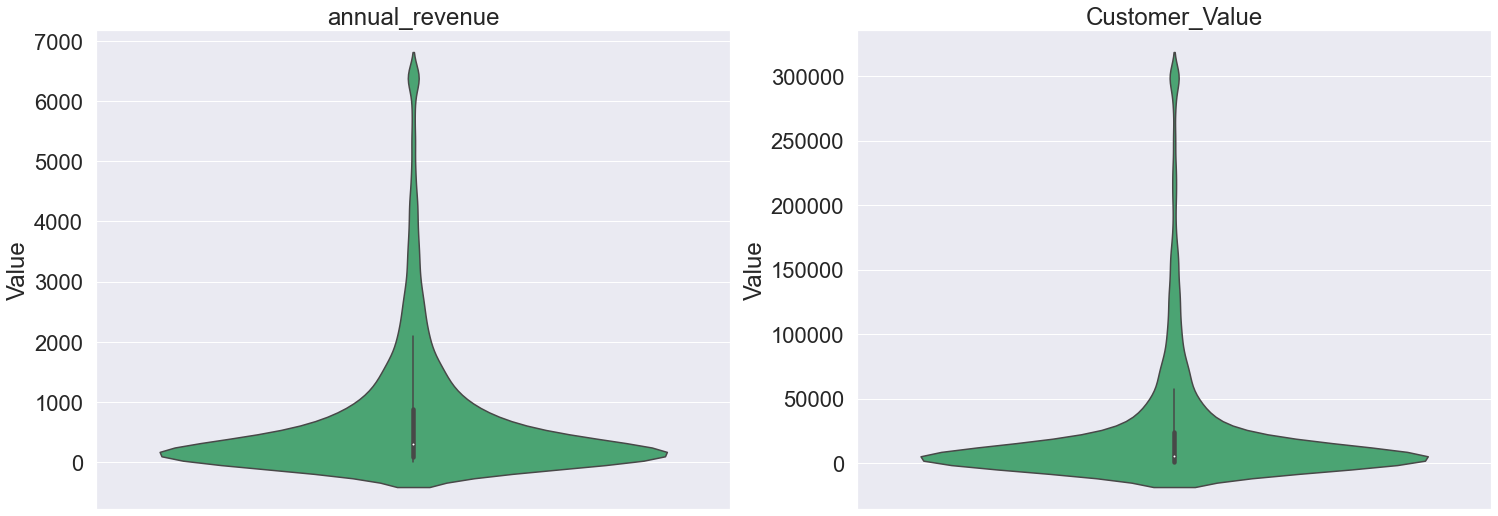

In [336]:
feature_num = list(enumerate(df3[['annual_revenue', 'Customer_Value']].columns))
feature_num
plt.figure(figsize = (25,125))
sns.set(font_scale = 2)

for i in feature_num:
    plt.subplot(12,2,i[0]+1)
    sns.violinplot(y = i[1],
                   data = df3,
                   color='mediumseagreen')

    plt.title(str(i[1]))
    plt.ylabel('Value')
    plt.xticks(rotation = 45)

## Review Correlated Features to Customer Value

<b>Action: </b> Review variables with high correlations and remove variables as necessary.

In [337]:
# Output any correlation values over 0.65 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > 0.69:
            print(index,value)
            
high_corr_and_check(df3)

('Credit_Card', 'DirectMail_SENT') 0.992838839185089
('ATMVisits_3_Mos', 'ATM_Trans_3_Mos') 0.9610650957809658
('Branch_Visits_3_Mos', 'Branch_Trans_3_Mos') 0.9448569209623414
('Liquid_Resources', 'Investment_Resources') 0.888401506104788
('signon_visit_3_Mos', 'signon_trans_3_Mos') 0.8774609145682707
('MOBILE_ACTIVE', 'Active_user') 0.8769890019012456
('annual_revenue', 'Customer_Value') 0.8529520444280905
('OLB_ACTIVE', 'Active_user') 0.8451541298263741
('Number_of_Children', 'Household_Size') 0.8067946567109111
('Number_of_Adults', 'Household_Size') 0.6953852390870283


In [338]:
df3.drop(columns=['DirectMail_SENT',
                  'ATMVisits_3_Mos',
                  'Branch_Visits_3_Mos',
                  'Investment_Resources', 
                  'signon_visit_3_Mos', 
                  'MOBILE_ACTIVE', 
                  'OLB_ACTIVE',
                  'Household_Size'],
        inplace=True)

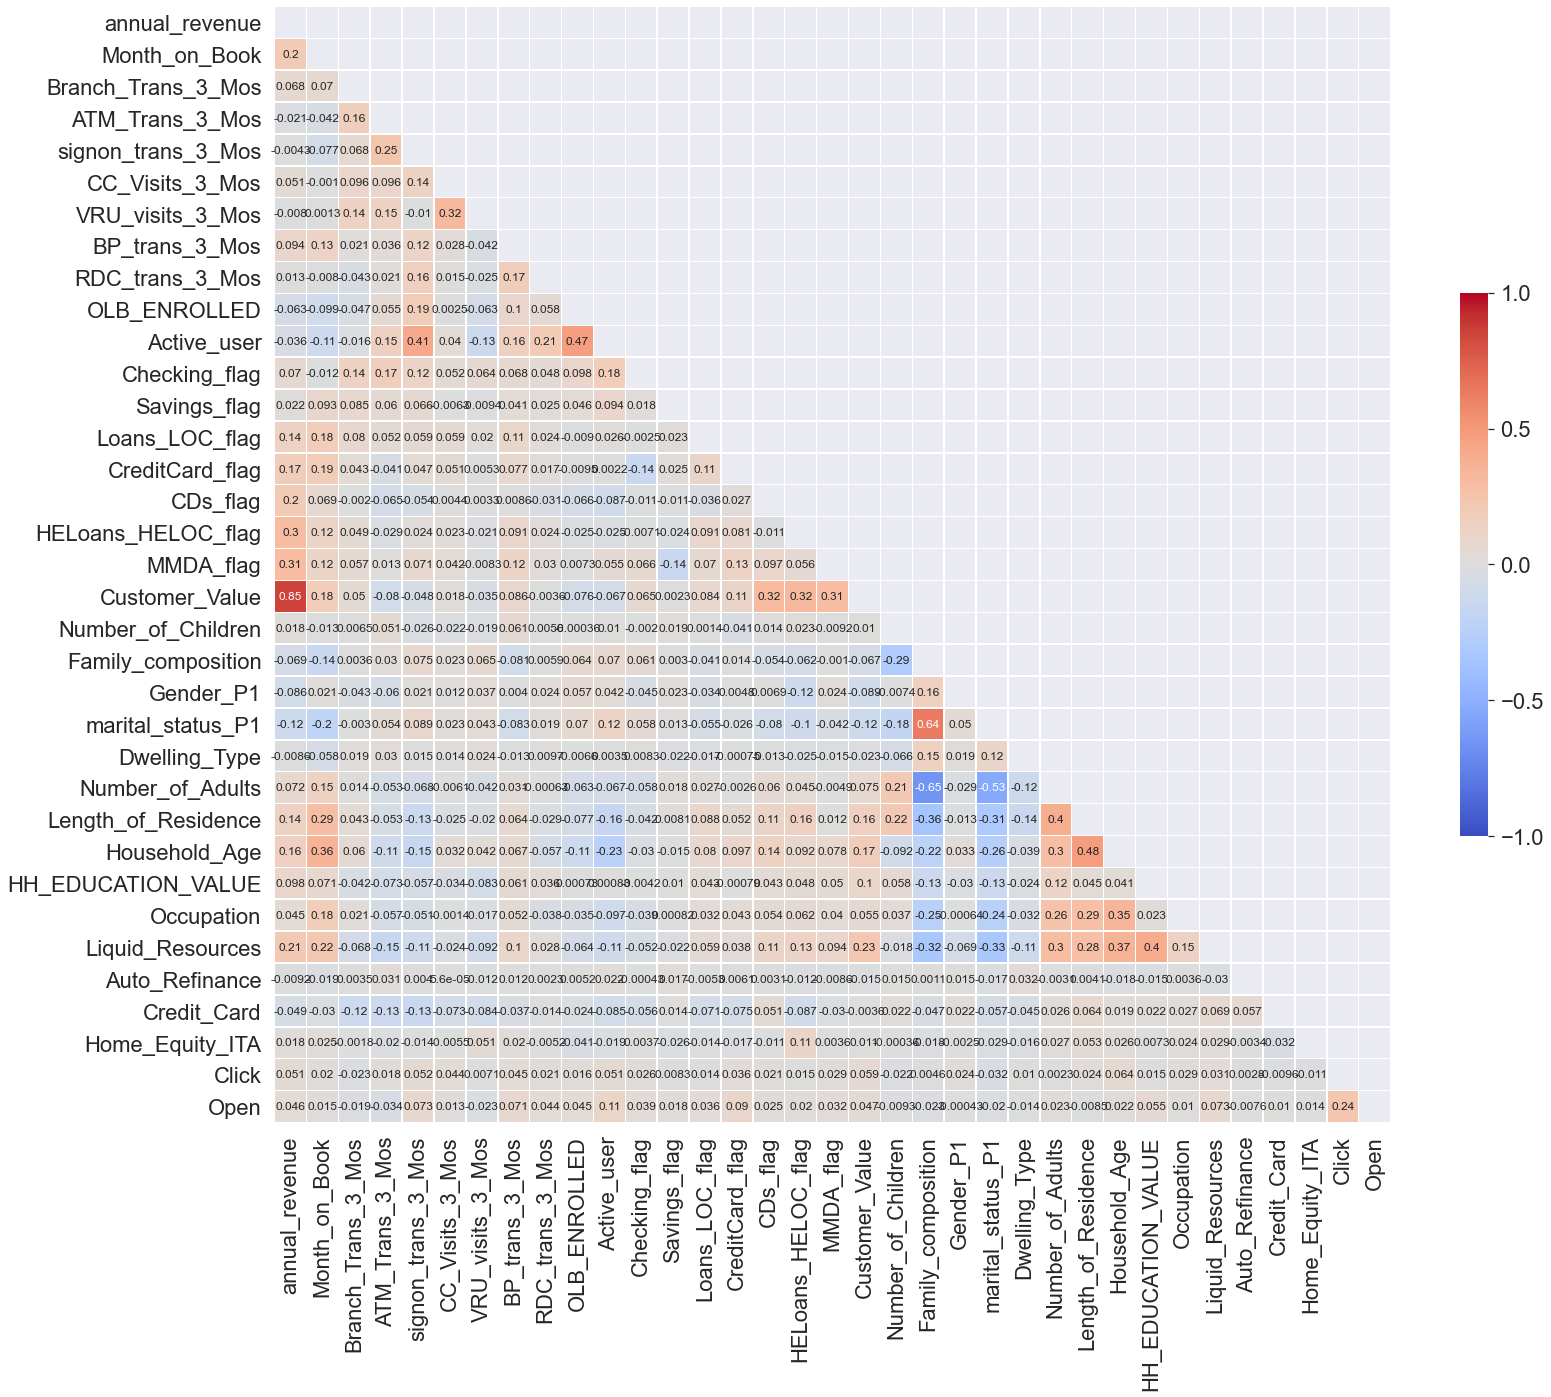

In [339]:
corr_matrix = df3.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(25, 25))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Visualisations

In [340]:
df_numeric = df3.select_dtypes(include='number')
df3[df_numeric.columns] = df3[df_numeric.columns].astype(int)
df3[df_numeric.columns[9:]] = df3[df_numeric.columns[9:]].astype(str)
df3['Customer_Value'] = df3['Customer_Value'].astype(float)

In [341]:
binary_cols=[]
multi_Value=[]
for col in df3.columns:
    if df3[col].dtype =='object':
        if df3[col].unique().shape[0]==2:
            binary_cols.append(col)
        else:
            multi_Value.append(col)
            
binary_cols

['OLB_ENROLLED',
 'Checking_flag',
 'Savings_flag',
 'Loans_LOC_flag',
 'CreditCard_flag',
 'CDs_flag',
 'HELoans_HELOC_flag',
 'MMDA_flag',
 'Gender_P1',
 'Auto_Refinance',
 'Credit_Card',
 'Home_Equity_ITA',
 'Click',
 'Open']

In [342]:
df3['Gender_P1'] = df3['Gender_P1'].replace({'1':'Male', '2':'Female'})
df3[binary_cols] = df3[binary_cols].replace({'0':'No', '1':'Yes'})

In [343]:
for col in df3.dtypes[df3.dtypes == object].index:
    print(col,'\n', df3[col].unique())

OLB_ENROLLED 
 ['Yes' 'No']
Active_user 
 ['1' '0' '2']
Checking_flag 
 ['Yes' 'No']
Savings_flag 
 ['No' 'Yes']
Loans_LOC_flag 
 ['No' 'Yes']
CreditCard_flag 
 ['No' 'Yes']
CDs_flag 
 ['No' 'Yes']
HELoans_HELOC_flag 
 ['No' 'Yes']
MMDA_flag 
 ['No' 'Yes']
Number_of_Children 
 ['0' '2' '4' '3' '6' '1' '5' '7' '8' '9']
Family_composition 
 ['8' '14' '6' '2' '7' '1' '12' '3' '11' '4' '13' '5' '10' '16']
Gender_P1 
 ['Female' 'Male']
marital_status_P1 
 ['1' '2' '3']
Dwelling_Type 
 ['1' '5' '0' '2' '3' '6']
Number_of_Adults 
 ['2' '1' '5' '3' '4']
Length_of_Residence 
 ['7' '8' '4' '5' '6' '3' '1' '2']
Household_Age 
 ['7' '6' '5' '4' '2' '3' '1']
HH_EDUCATION_VALUE 
 ['4' '2' '3' '5' '1' '0']
HH_INCOME2 
 ['6' '3' '2' '4' '5' '7' 'B' 'C' '8' '9' '1' 'A' 'D']
Occupation 
 ['14' '13' '0' '6' '10' '5' '9' '12' '20' '18' '8' '19' '2' '7' '17' '15']
Liquid_Resources 
 ['8' '3' '5' '1' '7' '2' '11' '4' '12' '6' '14' '10' '13' '9']
Auto_Refinance 
 ['No' 'Yes']
Credit_Card 
 ['No' 'Yes']
Home_

### Multi-value Variables Assessment

<b>Action: </b> Below are the multi-value variables that I would like to group based on my subjectivity:
+ Family_composition - Removing due to being a scattered
       - column_name: Household_type (4 variables total)
+ Kids - Binning as 
    - Has_kids: 
        - 1 = Yes
        - 0 = No
+ Number_of_Adults - Binning as
    - Multi_adult:
        - 1 = Yes
        - 0 = No
+ Length_of_Residence - Binning as       
    - Length_of_Resident_Bins:
        - New_Resident (1 year of less)
        - Established_Resident (1 - 5 years)
        - Long_time_resident (over 5 years)
+ Household_Age - Removing due to relevance (may add back later)
+ HH_INCOME2 - Binning as
    - HH_INCOME2_bins:
        - Lower_income = < 50000
        - Medium income = > 50000 & < 150000
        - High income = > 150000
+ Occupation - Removing due to majority of values missing
+ Liquid_Resources - Binning
    - Liquid_Resources_bins:
        - Low liquidity < 10000
        - Medium liquidity > 10000 & < 25000
        - High liquidity > 25000
    

In [344]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 36 columns):
annual_revenue         4753 non-null int32
Month_on_Book          4753 non-null int32
Branch_Trans_3_Mos     4753 non-null int32
ATM_Trans_3_Mos        4753 non-null int32
signon_trans_3_Mos     4753 non-null int32
CC_Visits_3_Mos        4753 non-null int32
VRU_visits_3_Mos       4753 non-null int32
BP_trans_3_Mos         4753 non-null int32
RDC_trans_3_Mos        4753 non-null int32
OLB_ENROLLED           4753 non-null object
Active_user            4753 non-null object
Checking_flag          4753 non-null object
Savings_flag           4753 non-null object
Loans_LOC_flag         4753 non-null object
CreditCard_flag        4753 non-null object
CDs_flag               4753 non-null object
HELoans_HELOC_flag     4753 non-null object
MMDA_flag              4753 non-null object
Customer_Value         4753 non-null float64
Number_of_Children     4753 non-null object
Family_composition   

In [345]:
df3['Number_of_Children'] = df3['Number_of_Children'].astype(int)
df3.loc[(df3['Number_of_Children']>0), 'Has_kids'] ='Yes'
df3.loc[(df3['Number_of_Children']==0), 'Has_kids'] ='No'

df3['Number_of_Adults'] = df3['Number_of_Adults'].astype(int)
df3.loc[(df3['Number_of_Adults']>0), 'Multi_Adult'] ='Yes'
df3.loc[(df3['Number_of_Adults']==1), 'Multi_Adult'] ='No'

# df3['Length_of_Residence'] = df3['Length_of_Residence'].astype(int)
# df3.loc[(df3['Length_of_Residence']<3), 'Length_of_Residence_Bins'] ='New_Resident'
# df3.loc[(df3['Length_of_Residence']>=3) & (df3['Length_of_Residence']<5), 'Length_of_Residence_Bins'] ='Established_Resident'
# df3.loc[(df3['Length_of_Residence']>4), 'Length_of_Residence_Bins'] ='Long_Time_Resident'

df3.loc[(df3['HH_INCOME2']=='A'), 'HH_INCOME2'] = 10
df3.loc[(df3['HH_INCOME2']=='B'), 'HH_INCOME2'] = 11
df3.loc[(df3['HH_INCOME2']=='C'), 'HH_INCOME2'] = 12
df3.loc[(df3['HH_INCOME2']=='D'), 'HH_INCOME2'] = 13
# df3['HH_INCOME2'] = df3['HH_INCOME2'].astype(int)
# df3.loc[(df3['HH_INCOME2']<5), 'HH_INCOME2_bins'] ='Lower_Income'
# df3.loc[(df3['HH_INCOME2']>=5) & (df3['HH_INCOME2']<10), 'HH_INCOME2_bins'] ='Medium_Income'
# df3.loc[(df3['HH_INCOME2']>9), 'HH_INCOME2_bins'] ='High_Income'

# df3['Liquid_Resources'] = df3['Liquid_Resources'].astype(int)
# df3.loc[(df3['Liquid_Resources']<6), 'Liquid_Resources_bins'] ='Low_liquidity'
# df3.loc[(df3['Liquid_Resources']>=6) & (df3['Liquid_Resources']<9), 'Liquid_Resources_bins'] ='Medium_liquidity'
# df3.loc[(df3['Liquid_Resources']>8), 'Liquid_Resources_bins'] ='High_liquidity'


# df3.drop(columns=['Family_composition',
#                   'Number_of_Children',
#                   'Number_of_Adults',
#                   'Length_of_Residence',
#                   'HH_INCOME2',
#                   'Occupation', 
#                   'Liquid_Resources',
#                   'Household_Age'
#                  ], 
#          inplace=True)

<b>Action: </b>Convert remaining multi-Value columns to named fields prior to making dummy variables.

In [346]:
df3.loc[df3['marital_status_P1']=='1', 'marital_status_P1'] = 'Married'
df3.loc[df3['marital_status_P1']=='2', 'marital_status_P1'] = 'Single'
df3.loc[df3['marital_status_P1']=='3', 'marital_status_P1'] = 'Unknown'

df3.loc[df3['Dwelling_Type']=='0', 'Dwelling_Type'] = 'Unknown'
df3.loc[df3['Dwelling_Type']=='1', 'Dwelling_Type'] = 'SingleFamily'
df3.loc[df3['Dwelling_Type']=='2', 'Dwelling_Type'] = 'MultiFamilyUnit'
df3.loc[df3['Dwelling_Type']=='3', 'Dwelling_Type'] = 'Business'
df3.loc[df3['Dwelling_Type']=='5', 'Dwelling_Type'] = 'Condo'
df3.loc[df3['Dwelling_Type']=='6', 'Dwelling_Type'] = 'MobileHome'

# df3.loc[df3['HH_EDUCATION_VALUE']=='0', 'HH_EDUCATION_VALUE'] = 'HighschoolDropout'
# df3.loc[df3['HH_EDUCATION_VALUE']=='1', 'HH_EDUCATION_VALUE'] = 'HighSchoolDropout'
# df3.loc[df3['HH_EDUCATION_VALUE']=='2', 'HH_EDUCATION_VALUE'] = 'HighSchool'
# df3.loc[df3['HH_EDUCATION_VALUE']=='3', 'HH_EDUCATION_VALUE'] = 'SomeCollege'
# df3.loc[df3['HH_EDUCATION_VALUE']=='4', 'HH_EDUCATION_VALUE'] = 'UnderGraduate'
# df3.loc[df3['HH_EDUCATION_VALUE']=='5', 'HH_EDUCATION_VALUE'] = 'GradSchool'

In [347]:
binary_cols=[]
multi_Value=[]
for col in df3.columns:
    if df3[col].dtype =='object':
        if df3[col].unique().shape[0]==2:
            binary_cols.append(col)
        else:
            multi_Value.append(col)
            
binary_cols

['OLB_ENROLLED',
 'Checking_flag',
 'Savings_flag',
 'Loans_LOC_flag',
 'CreditCard_flag',
 'CDs_flag',
 'HELoans_HELOC_flag',
 'MMDA_flag',
 'Gender_P1',
 'Auto_Refinance',
 'Credit_Card',
 'Home_Equity_ITA',
 'Click',
 'Open',
 'Has_kids',
 'Multi_Adult']

In [348]:
multi_Value

['Active_user',
 'Family_composition',
 'marital_status_P1',
 'Dwelling_Type',
 'Length_of_Residence',
 'Household_Age',
 'HH_EDUCATION_VALUE',
 'HH_INCOME2',
 'Occupation',
 'Liquid_Resources']

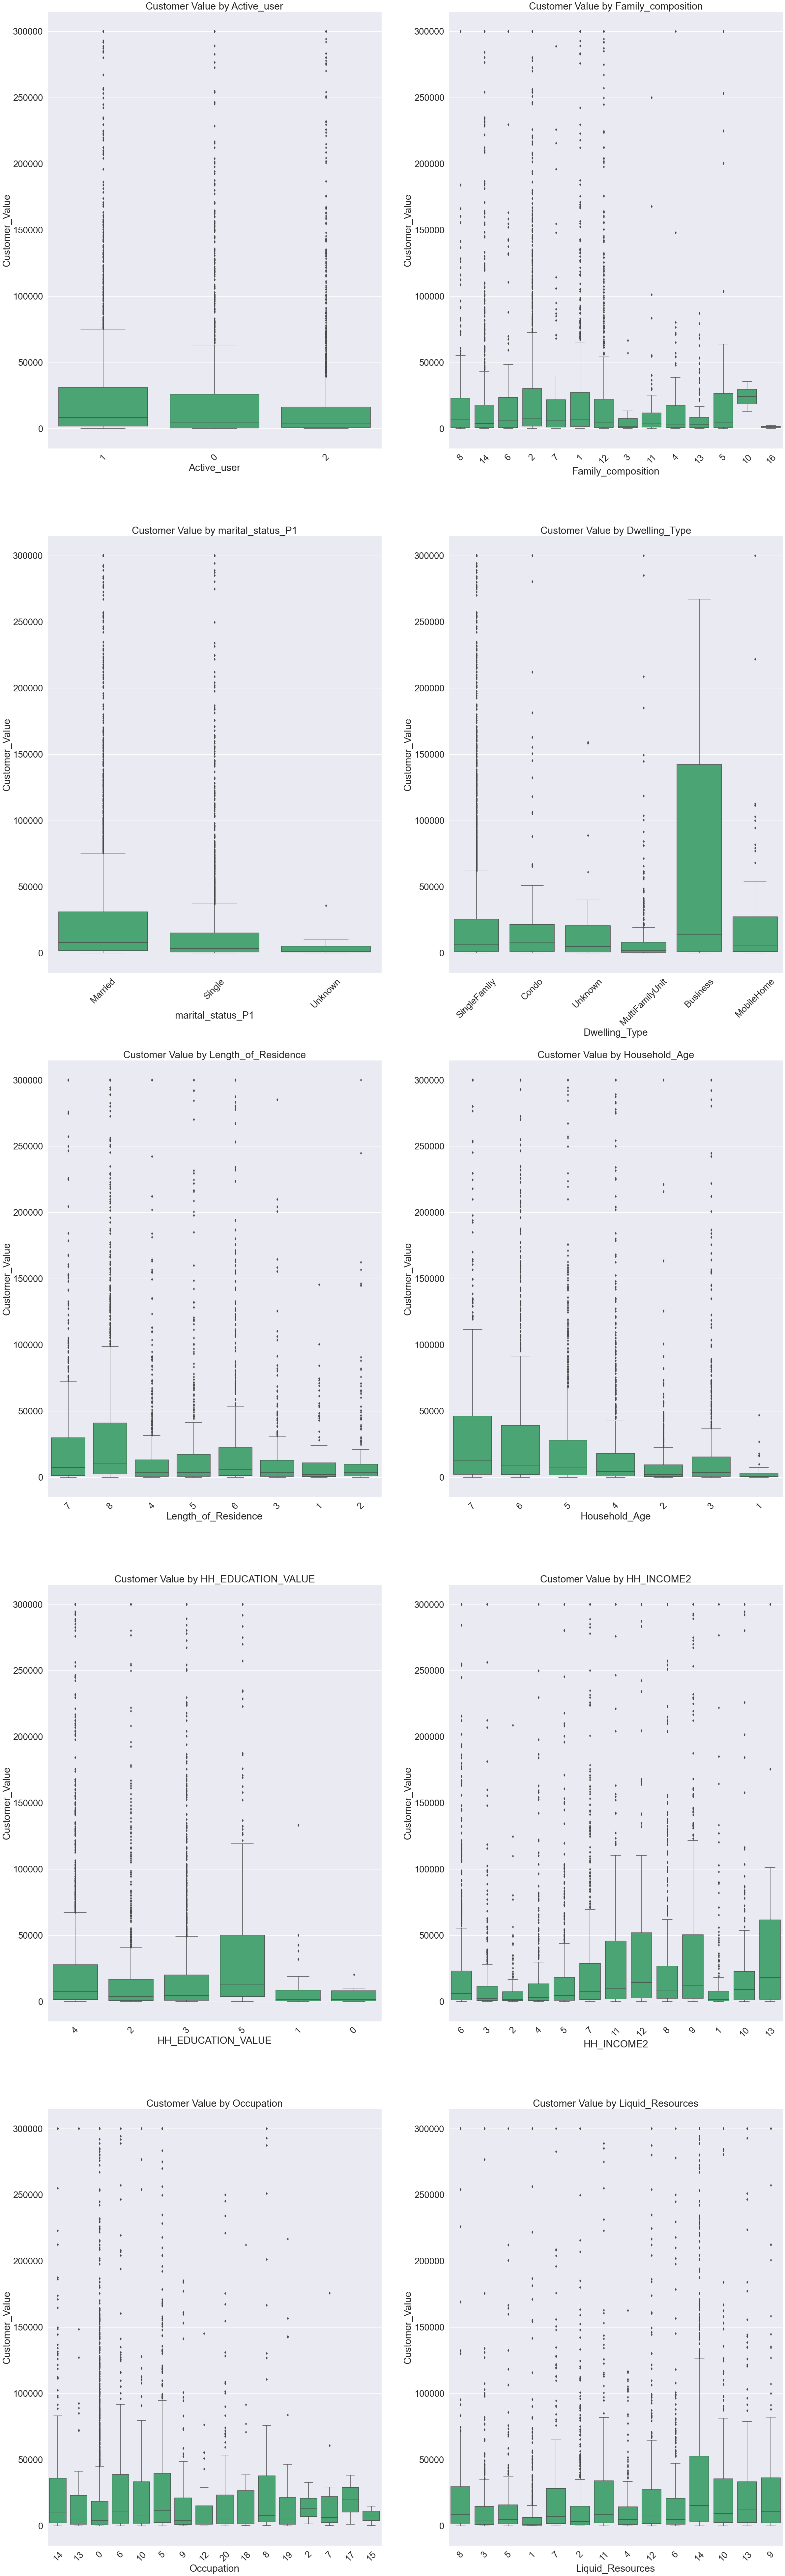

In [349]:
feature_num = list(enumerate(df3[multi_Value].columns))
feature_num

plt.figure(figsize = (40,200))
sns.set(font_scale = 2.5)

for i in feature_num:
    num_cols = 2
    num_rows = 7
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.boxplot(x = i[1],
                y='Customer_Value',
                data = df3,
                color='mediumseagreen',
                orient='v')
    
#     plt.ylabel('Customer Count')
    plt.title('Customer Value by '+str(i[1]))
    plt.xticks(rotation = 45)

<b> Assessment: </b> The Active user, Liquid_Resources, and Family_composition columns looks to be potentially useful. For this reason, I will be considering its use as a variable.

### Binary Variables Univariate Assessment

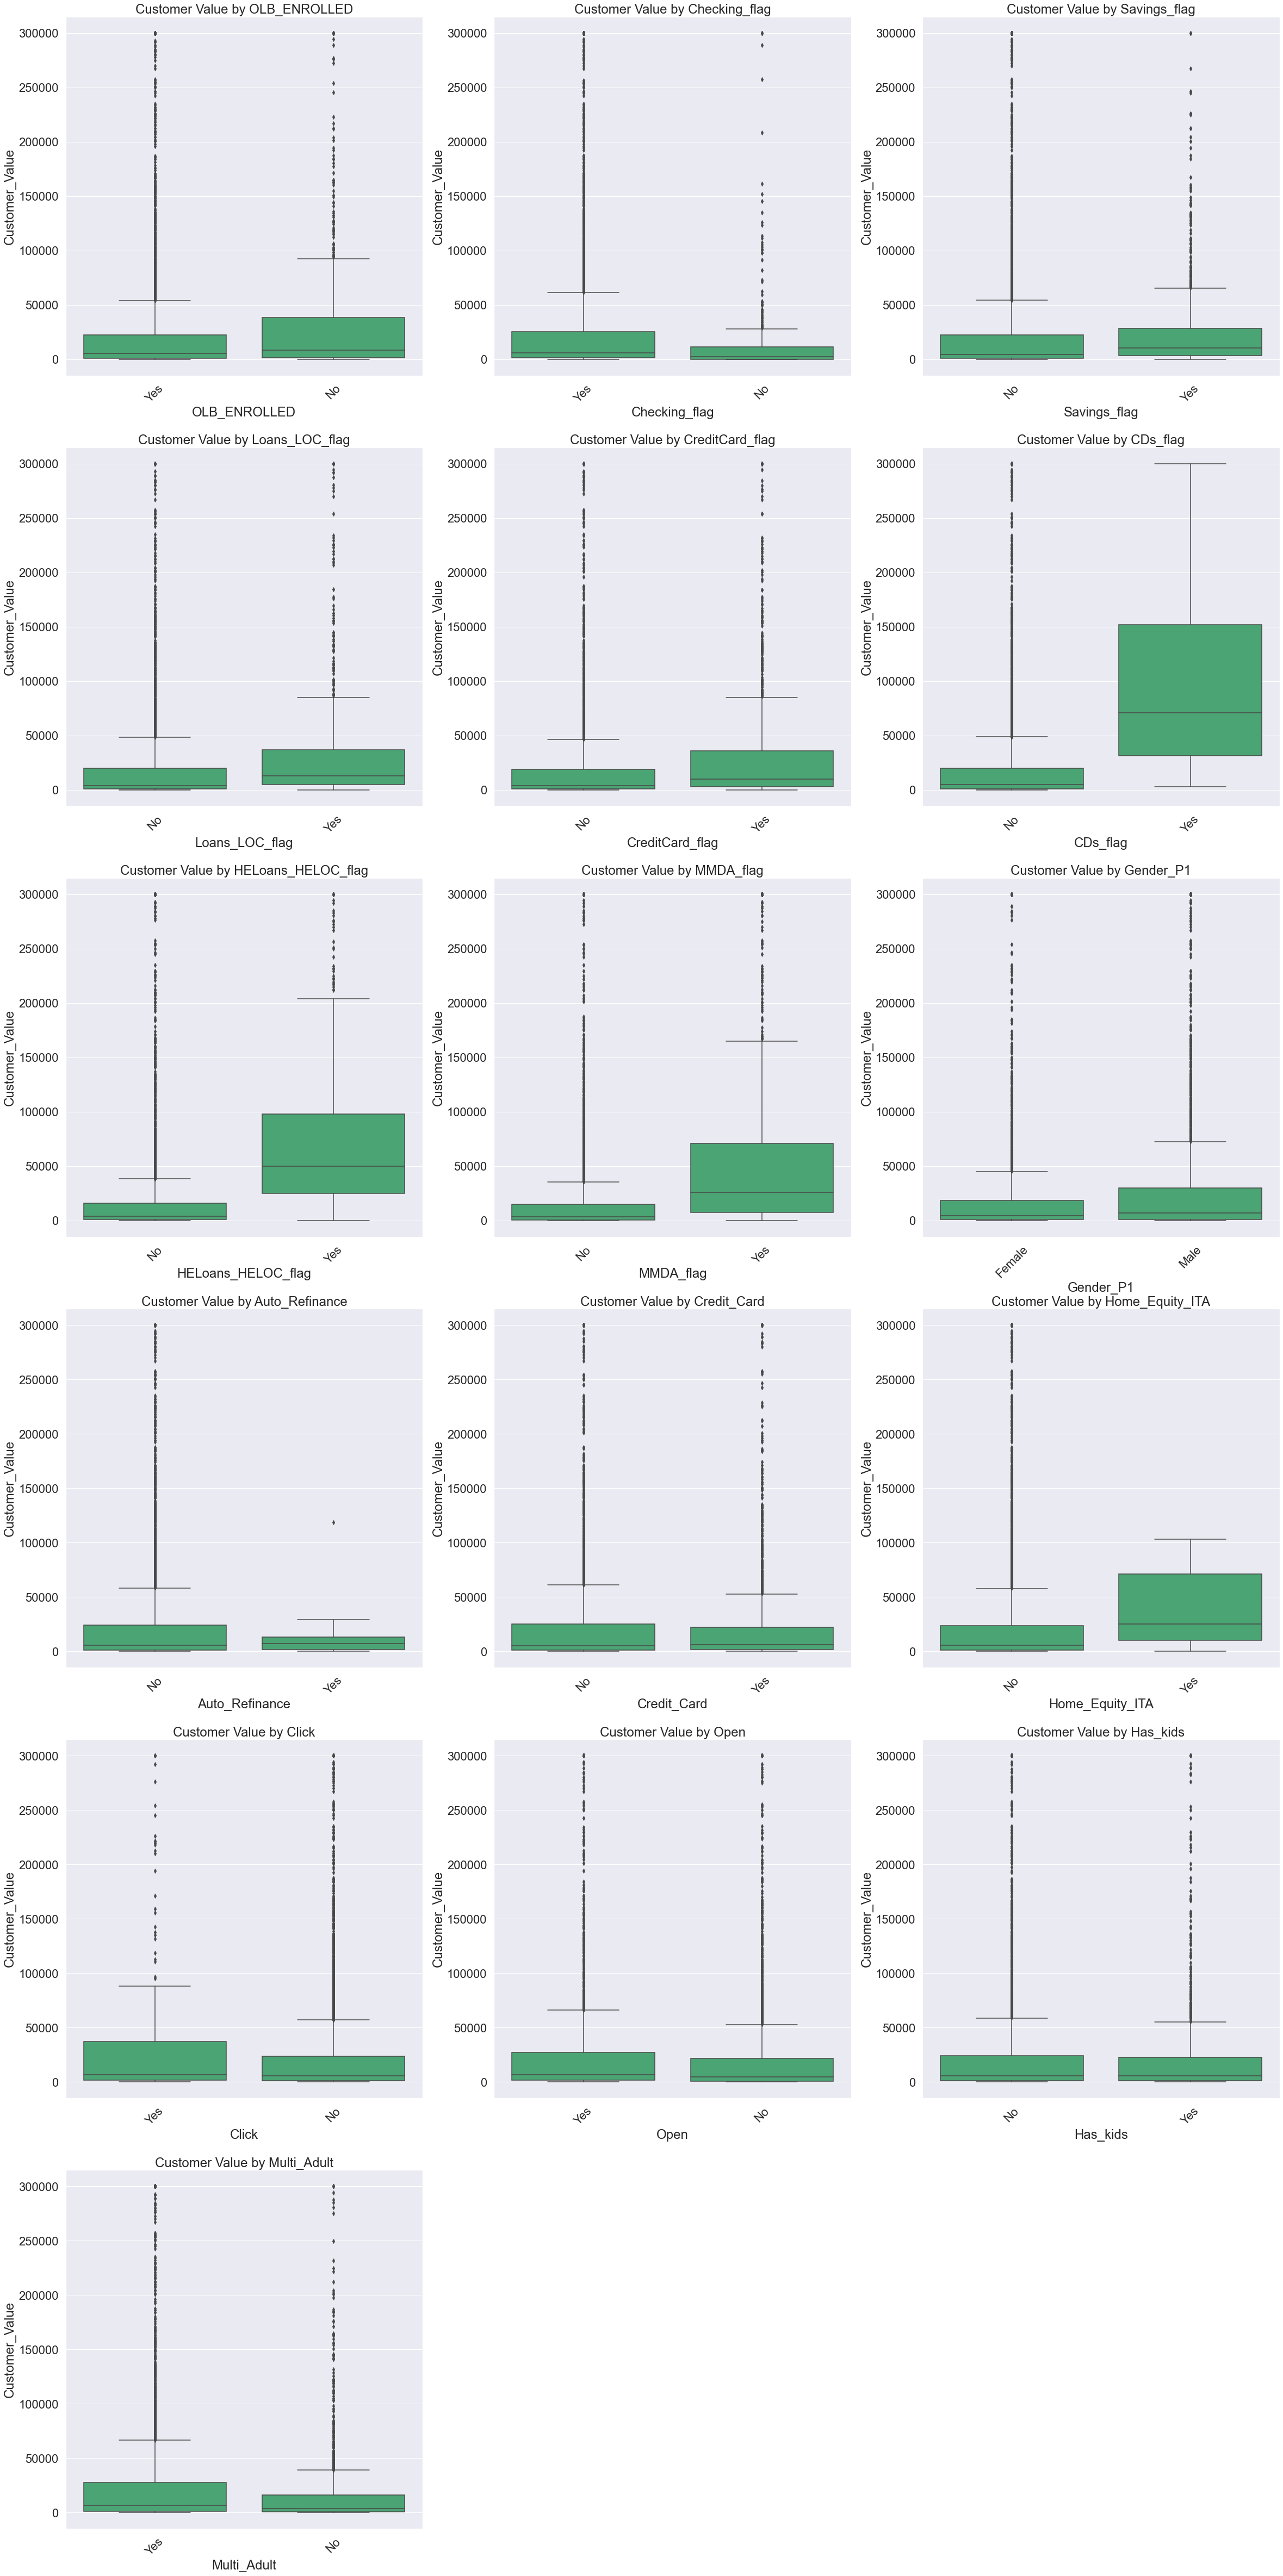

In [350]:
feature_num = list(enumerate(df3[binary_cols].columns))
feature_num

plt.figure(figsize = (40, 85))
sns.set(font_scale = 2)

for i in feature_num:
    plt.subplot(6,3,i[0]+1)
    sns.boxplot(x = i[1],
                y='Customer_Value',
                data = df3,
                color='mediumseagreen',
                orient='v')
    
#     plt.ylabel('Customer Count')
    plt.title('Customer Value by '+str(i[1]))
    plt.xticks(rotation = 45)

Some notable columns that stood out include:
+ CDs_flag
+ HELoans_HELOC_flag
+ MMDA_flag
+ Home_Equity_ITA

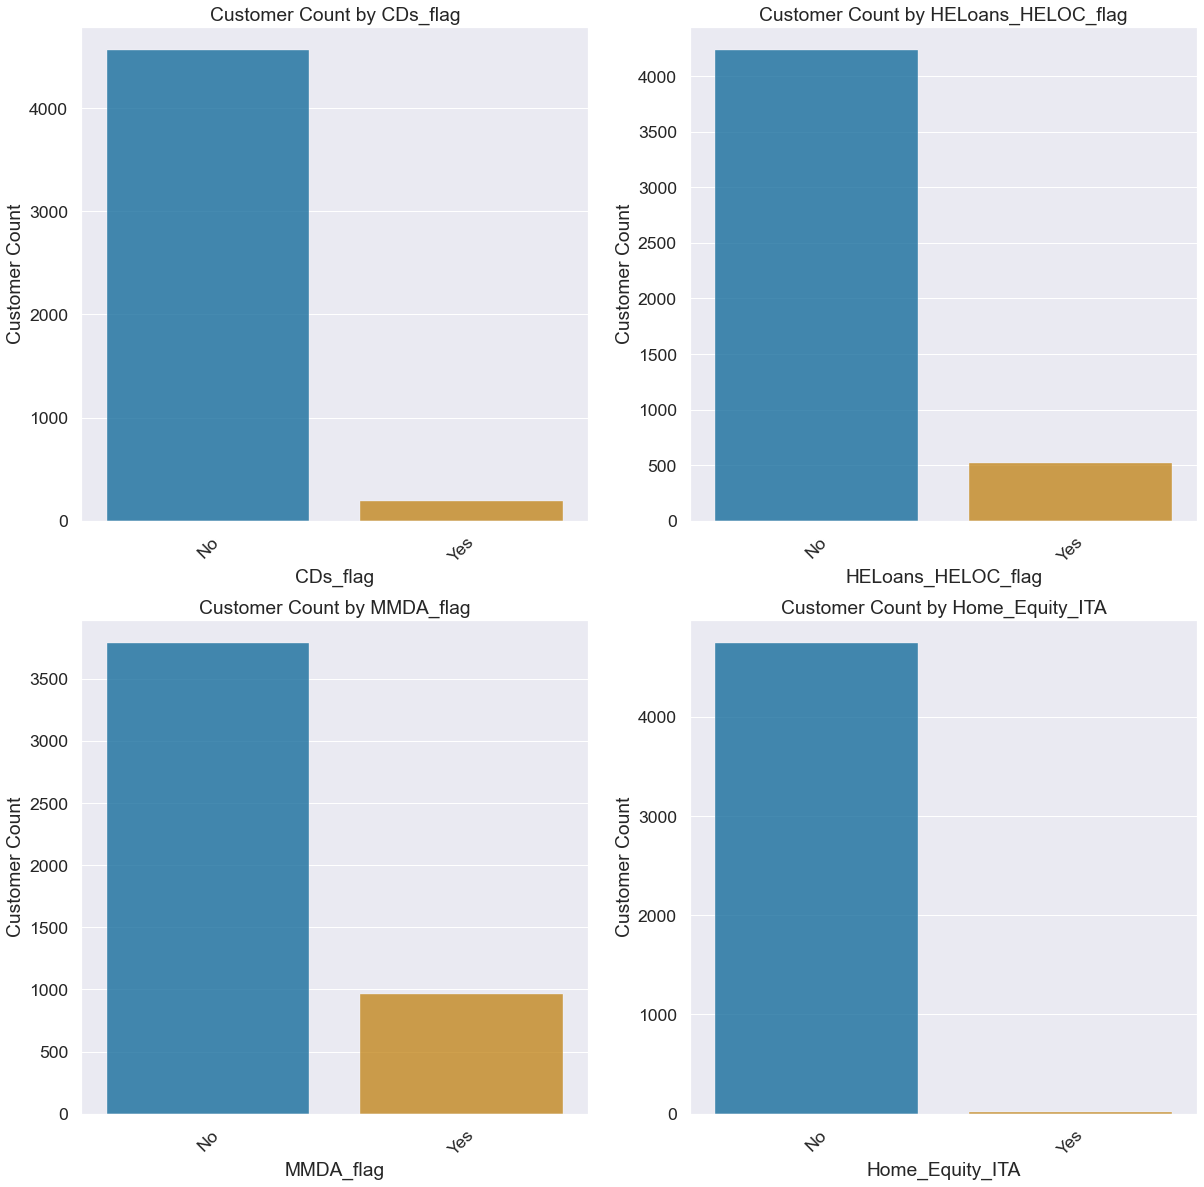

In [351]:
feature_obj = list(enumerate(df3[['CDs_flag', 
                                 'HELoans_HELOC_flag', 
                                 'MMDA_flag',
                                 'Home_Equity_ITA']].columns))


plt.figure(figsize = (20,20))
sns.set(font_scale = 1.6)

for i in feature_obj:
    num_cols = 2
    num_rows = 2
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.countplot(x = i[1],
                  data = df3,
                  palette='colorblind',
                  linewidth=0.4,
                  alpha=0.8
                 )
    
    plt.ylabel('Customer Count')
    plt.title('Customer Count by '+str(i[1]))
    plt.xticks(rotation = 45)

<b> Assessment: </b> The MMDA_flag and HELoans_HELOC_flag columns have significant numbers of the sample relative to the total that may be useful as a predictor in my model. For this reason, I will be considering its use as a variable.

### Numeric Variables Assessment

In [352]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 38 columns):
annual_revenue         4753 non-null int32
Month_on_Book          4753 non-null int32
Branch_Trans_3_Mos     4753 non-null int32
ATM_Trans_3_Mos        4753 non-null int32
signon_trans_3_Mos     4753 non-null int32
CC_Visits_3_Mos        4753 non-null int32
VRU_visits_3_Mos       4753 non-null int32
BP_trans_3_Mos         4753 non-null int32
RDC_trans_3_Mos        4753 non-null int32
OLB_ENROLLED           4753 non-null object
Active_user            4753 non-null object
Checking_flag          4753 non-null object
Savings_flag           4753 non-null object
Loans_LOC_flag         4753 non-null object
CreditCard_flag        4753 non-null object
CDs_flag               4753 non-null object
HELoans_HELOC_flag     4753 non-null object
MMDA_flag              4753 non-null object
Customer_Value         4753 non-null float64
Number_of_Children     4753 non-null int32
Family_composition    

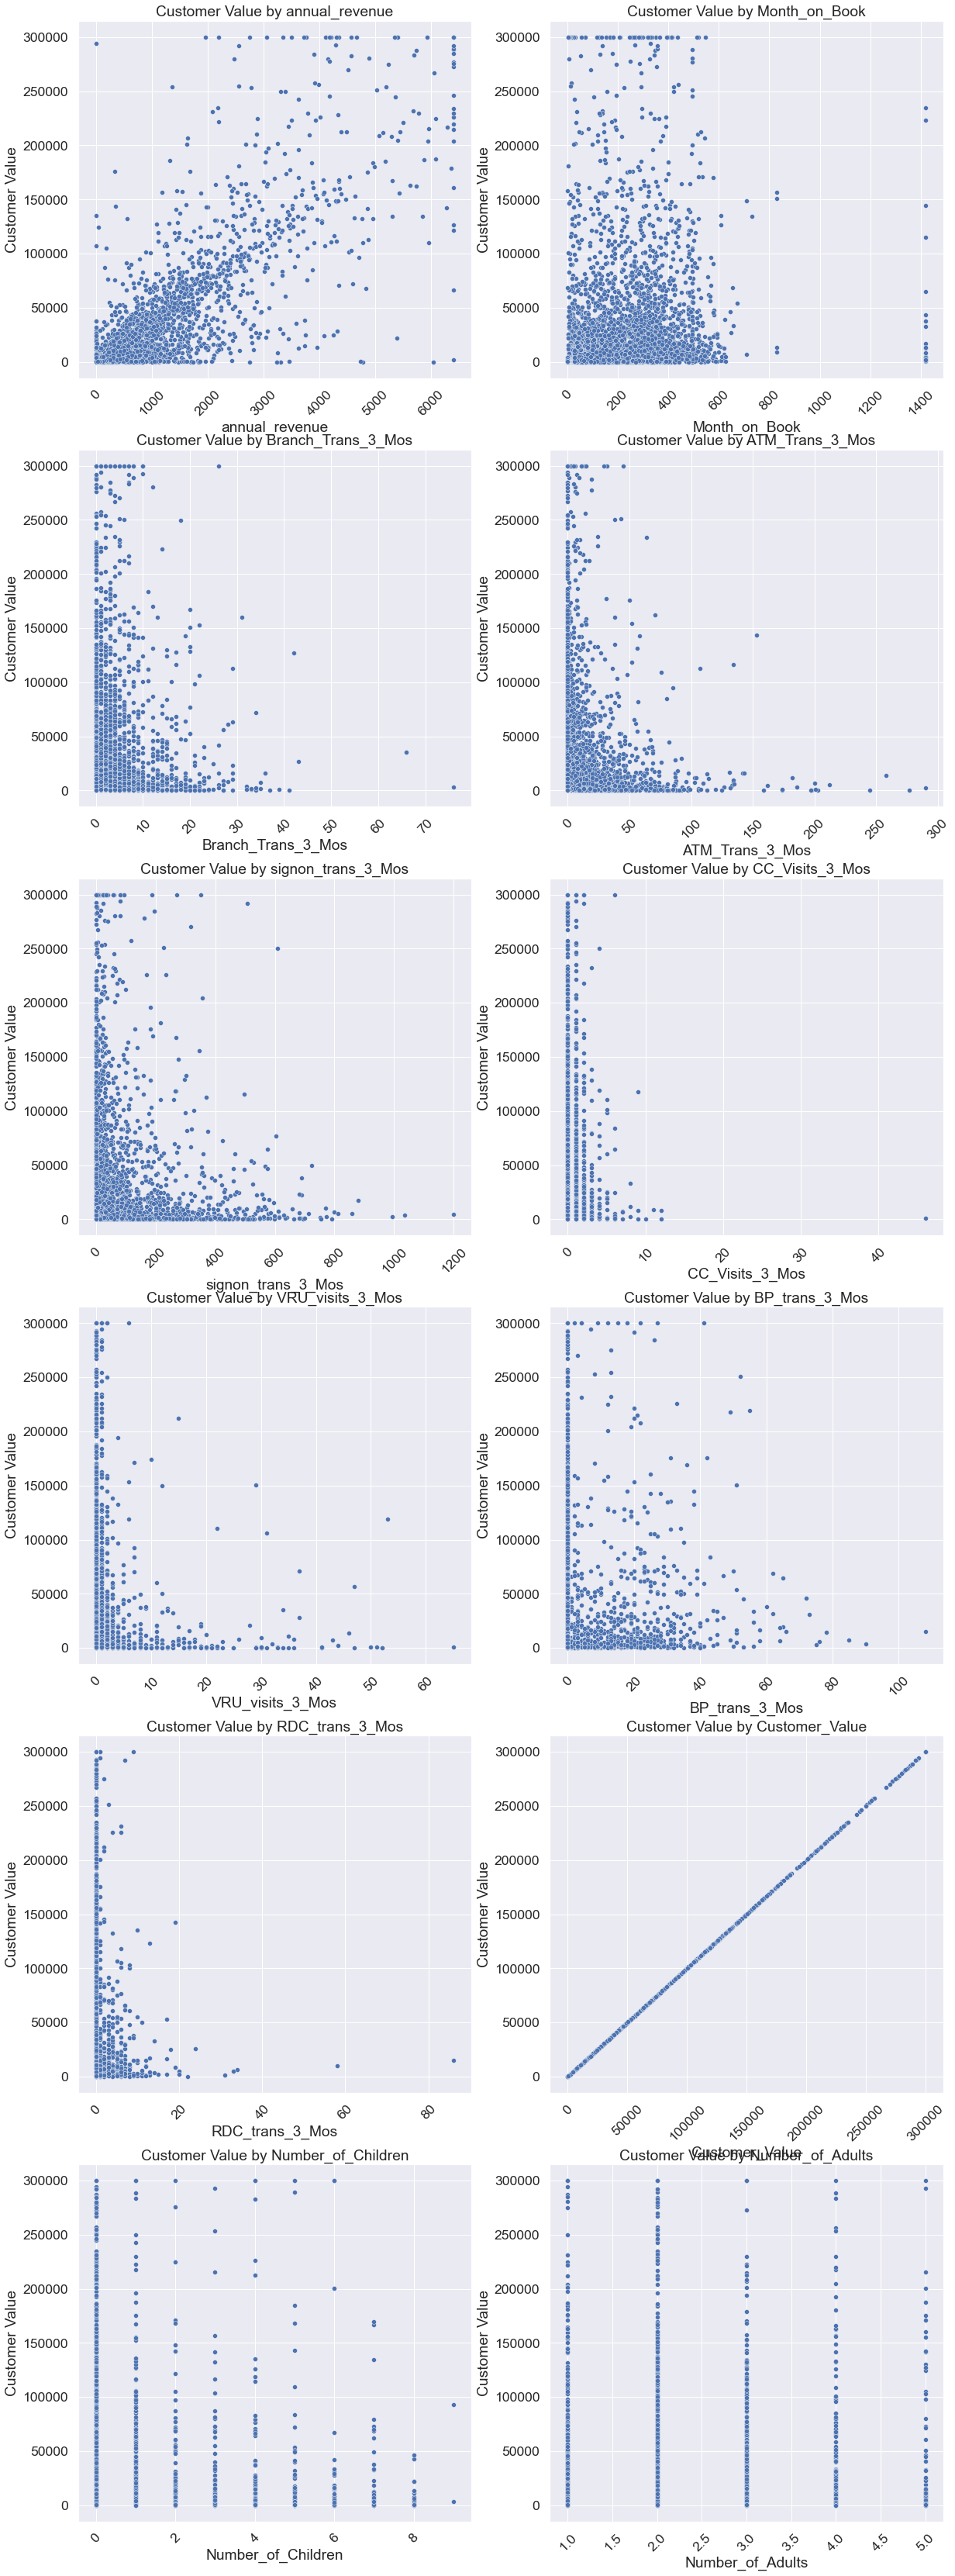

In [353]:
#select non-numeric variables
df_numeric = df3.select_dtypes(include='number')
#select the column names and convert to a list
df_numeric_columns = list(df_numeric.columns)
#select the columns, excluding the first two (Churn & ServiceAreaCode)
feature_obj = list(enumerate(df_numeric_columns))


plt.figure(figsize = (20,100))
sns.set(font_scale = 1.6)

for i in feature_obj:
    num_cols = 2
    num_rows = 10
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.scatterplot(data = df3,
                  x = i[1],
                  y='Customer_Value',
                  palette='colorblind',
                  linewidth=0.4
                 )
    
    plt.ylabel('Customer Value')
    plt.title('Customer Value by '+str(i[1]))
    plt.xticks(rotation = 45)

In [354]:
# plt.figure(figsize = (20,10))
# sns.set(font_scale = 1.6)
# sns.scatterplot(data=df6, x="annual_revenue", y="Customer_Value", hue='MMDA_flag')

In [355]:
# plt.figure(figsize = (20,10))
# sns.set(font_scale = 1.6)
# sns.scatterplot(data=df6, x="annual_revenue", y="Customer_Value", hue='HELoans_HELOC_flag')

<b> Assessment: </b> At first pass, 1st Party predictor variables I anticipate using are:

+ HELoans_HELOC_flag
+ Active User
+ MMDA_flag
+ annual_revenue

Below is the first initial pass at using a linear regression model using all variables as predictors.

In [356]:
df3.shape

(4753, 38)

# Identify and Assess Predictors for Data Model

In [357]:
binary_cols

['OLB_ENROLLED',
 'Checking_flag',
 'Savings_flag',
 'Loans_LOC_flag',
 'CreditCard_flag',
 'CDs_flag',
 'HELoans_HELOC_flag',
 'MMDA_flag',
 'Gender_P1',
 'Auto_Refinance',
 'Credit_Card',
 'Home_Equity_ITA',
 'Click',
 'Open',
 'Has_kids',
 'Multi_Adult']

In [358]:
multi_Value

['Active_user',
 'Family_composition',
 'marital_status_P1',
 'Dwelling_Type',
 'Length_of_Residence',
 'Household_Age',
 'HH_EDUCATION_VALUE',
 'HH_INCOME2',
 'Occupation',
 'Liquid_Resources']

<b>Action: </b>Convert all binary columns values to 0/1 for analysis. Review remaining multi-Value columns and convert via dummy variables.

In [359]:
df3['Gender_P1'] = df3['Gender_P1'].replace({'Male':1, 'Female':2})
df3[binary_cols] = df3[binary_cols].replace({'No':0, 'Yes':1})

In [360]:
pd.value_counts(df3['Active_user'])

2    1889
1    1617
0    1247
Name: Active_user, dtype: int64

# Week 3 Assignment - END

In [361]:
df3.to_csv('modified/week4_df.csv', index=False)

# Prepare the dataset for Week 4 Assignment